<h3>1. Prepare Libraries</h3>

In [1]:
import re
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
lemmatizer = nltk.wordnet.WordNetLemmatizer()

def simplify_input(content):
    content = re.sub("\\s", " ", content)
    content = re.sub("\\d", "", content)
    content = re.sub("[;]", "", content) # please comment this out if punctuation is important for our task.
    content = content.lower().split()
    return content

def stemming(content):
    le_content = str("")
    for string in content:
        le_content += lemmatizer.lemmatize(string, pos="v") + " "
    le_2 = str("")
    for s in le_content.split():
        le_2 += lemmatizer.lemmatize(s, pos='a') + " "
    le_3 = str("")
    for s in le_2.split():
        le_3 += lemmatizer.lemmatize(s, pos='n') + " "
    return le_3

In [2]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

### 

<h3>2. Loading dataset and Lemmatization</h3>

In [3]:
# nltk.download('wordnet')

source_location = "/kaggle/input/ao3-v5-8k-multigenres/"
data = pd.read_csv(source_location + 'AO3EntireWork_v5_Word8k_MultiGenres.csv', index_col = False)

# data = pd.read_csv("../../ScrapingAOW/AO3EntireWork_v5_Word8k_MultiGenres.csv", index_col = False)

# data = data.sample(n=3000, random_state=42)
data['simplified_input'] = data['content'].map(lambda x: simplify_input(x))
data['simplified_input'] = data['simplified_input'].map(lambda x: stemming(x))

In [4]:
data_backup = data

In [5]:
#Import libraries
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, ReformerForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

# Preprocessing: Split genres into lists for multi-label encoding
data['genres_list'] = data['genres'].apply(lambda x: x.split(','))

# Multi-Label Binarization
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(data['genres_list'])

In [7]:
len(data)

5803

In [8]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(data['simplified_input'], encoded_labels, test_size=0.2, random_state=42)

In [9]:
import torch
from transformers import AutoTokenizer, ReformerForSequenceClassification, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("google/reformer-crime-and-punishment")
# max_length = 8192
# tokenizer = AutoTokenizer.from_pretrained('google/reformer-crime-and-punishment')

# if tokenizer.pad_token is None:
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    
# test_encodings = tokenizer(
#     test_texts.tolist(),
#     truncation=True,
#     padding='max_length',
#     max_length=max_length,
#     return_tensors='pt'
# )

<h3> 3. Tokenize the Text with Reformer model </h3>

In [10]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('google/reformer-crime-and-punishment')
max_length = 8192 #524288

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

train_encodings = tokenizer(
    train_texts.tolist(),
    padding='max_length', 
    truncation=True,
    max_length = max_length,
    return_tensors='pt'
)
test_encodings = tokenizer(
    test_texts.tolist(),
    padding='max_length', 
    truncation=True,
    max_length = max_length,
    return_tensors='pt'
)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/323k [00:00<?, ?B/s]

In [11]:
torch.cuda.device_count()

2

In [12]:
import gc
gc.collect()

12

In [13]:

from torch.optim import AdamW
# Load the model
num_labels = len(mlb.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import ReformerConfig, ReformerModel
conf = ReformerConfig.from_pretrained('google/reformer-crime-and-punishment', num_labels=num_labels)
conf.axial_pos_embds = False 

# model = AutoModelForSequenceClassification.from_pretrained('google/reformer-crime-and-punishment', num_labels=num_labels)
model = ReformerForSequenceClassification.from_pretrained("google/reformer-crime-and-punishment", config=conf)
model = model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
criterion = torch.nn.BCEWithLogitsLoss()

# Create DataLoader
batch_size = 1
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

pytorch_model.bin:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

You might want to disable causal masking for sequence classification
Some weights of ReformerForSequenceClassification were not initialized from the model checkpoint at google/reformer-crime-and-punishment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'reformer.embeddings.position_embeddings.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(321, 256)

<h3>4. Model training & validation</h3>

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

# Initialize lists to store metrics
training_losses = []
validation_losses = []
validation_accuracies = []
hamming_losses = []
label_based_accuracies = []
best_model_epoch = -1
best_model_loss = float('inf')
best_model_accuracy = 0
best_model_hamming = 0
best_model_label_accuracy = 0
best_model_validation_loss = 0

# Parameters for early stopping and fine-tuning
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Best validation loss seen so far
epochs_no_improve = 0  # Counter for epochs without improvement

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training loop
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training phase
    for batch in train_dataloader:
        b_input_ids, b_attention_mask, b_labels = (t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        loss = criterion(outputs.logits, b_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}: Training Loss = {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_attention_mask, b_labels = (t.to(device) for t in batch)
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            loss = criterion(outputs.logits, b_labels)
            val_loss += loss.item()

            # Store predictions and true labels
            preds = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (preds > 0.3).astype(int)  # Apply threshold for multi-label classification
            all_preds.extend(preds)
            all_labels.extend(b_labels.cpu().numpy())

    avg_val_loss = val_loss / len(test_dataloader)
    validation_losses.append(avg_val_loss)

    # Calculate metrics
    val_accuracy = accuracy_score(all_labels, all_preds)
    hamming = hamming_loss(all_labels, all_preds)

    # Label-based accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    label_correct = (all_preds == all_labels).sum(axis=0)
    label_total = all_labels.shape[0]
    label_accuracy = label_correct / label_total
    avg_label_accuracy = label_accuracy.mean()
    label_based_accuracies.append(avg_label_accuracy)

    validation_accuracies.append(val_accuracy)
    hamming_losses.append(hamming)

    print(f"Epoch {epoch + 1}: Validation Loss = {avg_val_loss:.4f}, Perfect Prediction Accuracy = {val_accuracy:.4f}, "
          f"Hamming Loss = {hamming:.4f}, Partial Prediction Accuracy = {avg_label_accuracy:.4f}")

    # Early stopping and learning rate adjustment
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_epoch = epoch + 1
        best_model_accuracy = val_accuracy
        best_model_hamming = hamming
        best_model_label_accuracy = avg_label_accuracy
        best_model_validation_loss = avg_val_loss
        print("Validation loss improved. Saving model...")
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")
        scheduler.step(avg_val_loss)

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}.")
        break

Epoch 1: Training Loss = 0.4920
Epoch 1: Validation Loss = 0.4753, Perfect Prediction Accuracy = 0.0741, Hamming Loss = 0.2246, Partial Prediction Accuracy = 0.7754
Validation loss improved. Saving model...
Epoch 2: Training Loss = 0.4712
Epoch 2: Validation Loss = 0.4750, Perfect Prediction Accuracy = 0.0767, Hamming Loss = 0.2295, Partial Prediction Accuracy = 0.7705
Validation loss improved. Saving model...
Epoch 3: Training Loss = 0.4698
Epoch 3: Validation Loss = 0.4746, Perfect Prediction Accuracy = 0.0706, Hamming Loss = 0.2140, Partial Prediction Accuracy = 0.7860
Validation loss improved. Saving model...
Epoch 4: Training Loss = 0.4692
Epoch 4: Validation Loss = 0.4743, Perfect Prediction Accuracy = 0.0810, Hamming Loss = 0.2264, Partial Prediction Accuracy = 0.7736
Validation loss improved. Saving model...
Epoch 5: Training Loss = 0.4685
Epoch 5: Validation Loss = 0.4747, Perfect Prediction Accuracy = 0.0620, Hamming Loss = 0.2407, Partial Prediction Accuracy = 0.7593
No impr

<b>Expectation:</b>
1. Training and Validation Loss: Line graph comparing loss during training and validation.
2. Validation Accuracy: Should show improvement in accuracy across epochs.
3. Hamming Loss: Should decrease over epochs.
4. Label-Based Accuracy: Should increase as the model learns

<h3>5. Classification report & plot charts</h3>


Detailed Classification Report:
              precision    recall  f1-score   support

      Action       0.50      0.01      0.01       194
   Adventure       0.00      0.00      0.00       179
      Comedy       0.30      0.19      0.23       282
       Crime       0.16      0.02      0.03       204
     Fantasy       0.23      0.24      0.24       266
      Horror       0.00      0.00      0.00       199
     Mystery       0.38      0.10      0.16       152
     Romance       0.41      1.00      0.58       479
      Sci-Fi       0.00      0.00      0.00       187
 Superheroes       0.00      0.00      0.00       125

   micro avg       0.37      0.27      0.31      2267
   macro avg       0.20      0.15      0.13      2267
weighted avg       0.23      0.27      0.19      2267
 samples avg       0.38      0.26      0.29      2267



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


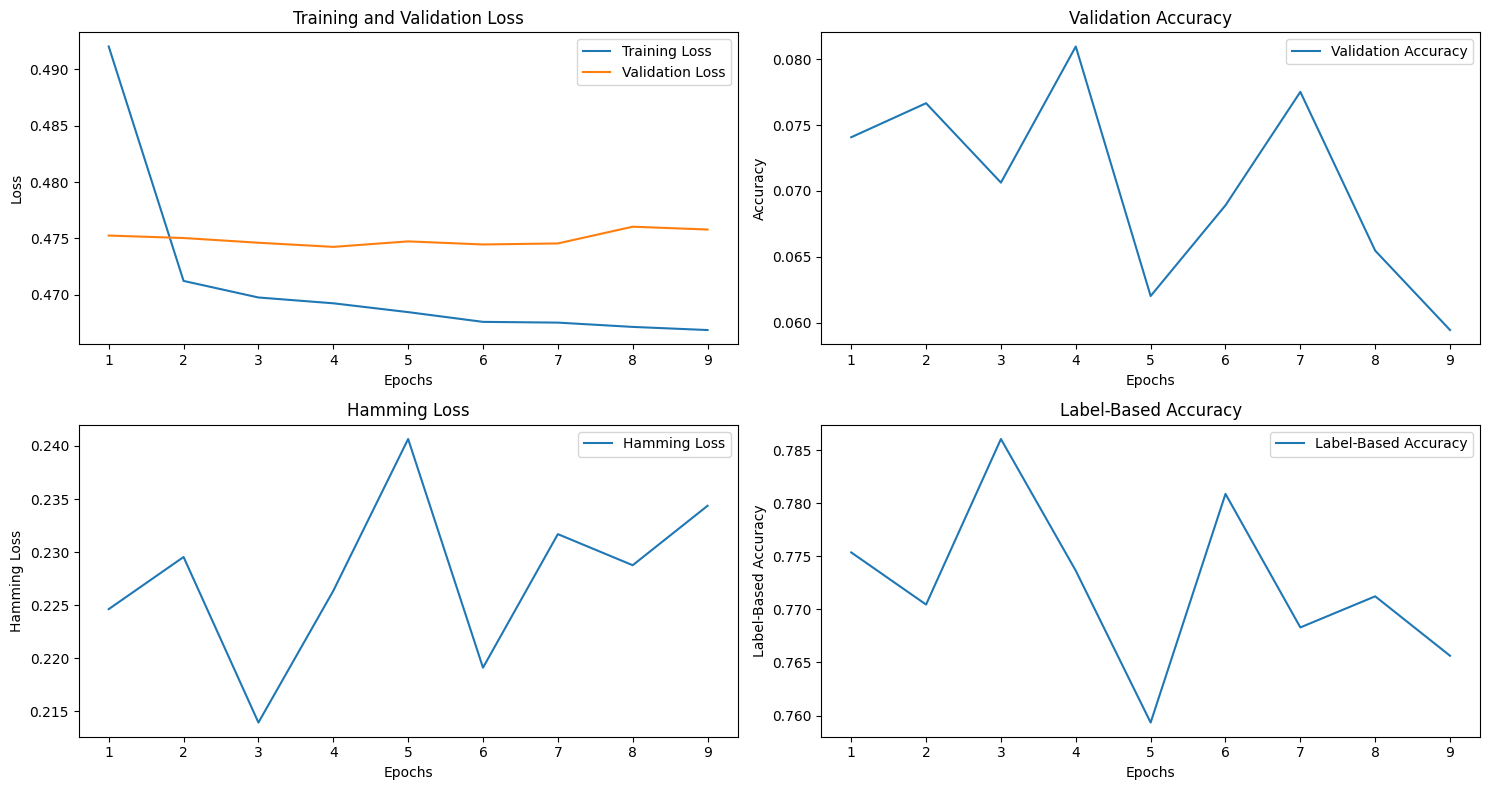

In [16]:
# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=mlb.classes_))

# Plot Training and Validation Metrics
plt.figure(figsize=(15, 8))

# Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Hamming Loss
plt.subplot(2, 2, 3)
plt.plot(range(1, len(hamming_losses) + 1), hamming_losses, label='Hamming Loss')
plt.title('Hamming Loss')
plt.xlabel('Epochs')
plt.ylabel('Hamming Loss')
plt.legend()

# Label-Based Accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, len(label_based_accuracies) + 1), label_based_accuracies, label='Label-Based Accuracy')
plt.title('Label-Based Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Label-Based Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<h3>--- Completed ---</h3>